# GenFL - Posterior from a learnt Prior

This notebook shows an example of how to reproduce some results from the paper `Federated Learning with Nonvacuous Generalisation Bounds`.
Specifically the ones from Table 1 : no KL penalty - 100 clients - Learnt prior - $f_1$

Abstract

We introduce a novel strategy to train randomised predictors in federated learning, where each node of the network aims at preserving its privacy by releasing a local predictor but keeping secret its training dataset with respect to the other nodes. We then build a global randomised predictor which inherits the properties of the local private predictors in the sense of a PAC-Bayesian generalisation bound. We consider the synchronous case where all nodes share the same training objective (derived from a generalisation bound), and the asynchronous case where each node may have its own personalised training objective. We show through a series of numerical experiments that our approach achieves a comparable predictive performance to that of the batch approach where all datasets are shared across nodes. More over the predictors are supported by numerically nonvacuous generalisation bounds while preserving privacy for each node. We explicitly compute the increment on predictive performance and generalisation bounds between batch and federated settings, highlighting the price to pay to preserve privacy

# Prerequisite

You need to complete the first notebook : `1. GenFL FL-SOB Prior.ipynb` before continuing. You specifically need a model prior produced by `GenFL_prior.py` and should be located somewhere in `./outputs/GenFL_Prior/[Date]/[Time]/[overrides]/checkpoint_round_*.pth`

This notebook has 2 main parts:
1. Perez FL Scenario 
2. Dziugaite FL Scenario

These parts are computably independant (still needs the corresponding parts from first notebook), however explanation are not independant.

# Startup

The code is meant to be used as a bash CLI. For pedagogic reasons, let's see it through a notebook file.

In [ ]:
%cd ..

## 1. Perez FL Scenario

Now let's run the code. We will produce a posterior with a config file in `./conf/scenario/perez_posterior_learnt.yaml` using the default configuration `./conf/genfl_posterior.yaml`.

You can see in the configuration file, that the neural network is a `ProbNNet4lPerez` than you can find `./core/model.py`. It's a stochastic neural network (SNN), we will train it to get a Posterior from a -learnt- prior

### IMPORTANT

In order to load the model prior, you need to specify the directory which contains the `checkpoint_round_*.pth` that is to say: `./outputs/GenFL_Prior/[Date]/[Time]/[overrides]` in the variable `resume_checkpoint_prior`

- You can either specify it in the command line:  
    Be careful, if there is a `=` in the path, you have to append `\` in front of the `=` (i.e. `\=`) (see the next cell)

- or specify it in the config file:
    I advice you to add `./conf/experiment` folder in which you create a new `notebook_2.yaml` in which there is:
    ```yaml
        # @package _global_

        # Resume Params
        resume_checkpoint_prior: path_to_code/outputs/GenFL_Prior/[Date]/[Time]/+scenario=perez_prior # Mandatory
    ```
    and then the bash command is:
    ```bash
    python GenFL_posterior.py +scenario=perez_posterior_learnt +experiment=notebook_2
    ```

For fast (debug feature) computation, we will use `dryrun=True` (almost all loops once). Otherwise, with `dryrun=False`, it takes several hours (and we don't get the result from the paper, see below for explanation)

In [ ]:
%%bash

python GenFL_posterior.py \
    +scenario=perez_posterior_learnt \
    resume_checkpoint_prior='path_to_code/outputs/GenFL_Prior/[Date]/[Time]/+scenario\=perez_prior' \
    dryrun=True \

As always a directory has been created at `./outputs/GenFL_Posterior/[Date]/[Time]/+scenario=perez_posterior`. Check the log file to verify that everything has gone right.  
You can check the `/metrics` folder which has a lot more files than in the prior scenario.

To summarize briefly all the metrics:
- `[metric_name]_Metrics_tmp.png` is the name format
- `[metric_name]_c_Metrics_tmp.png`, "c" stands for clients, which are some "local metrics" aggregated metrics computed only in the `evaluate` method in `./core/client.py`. (For instance, risk_01 is the generalisation bound for all the client, whereas risk_01_c is the aggregation of all local generalisation bounds of each client)
- `[metric_name]_[ens/mean/stch]_Metrics_tmp.png` are the metrics from the [`testEnsemble`, `testPosteriorMean`, `testStochastic`] functions in `./core/train.py` (mostly from (centralized) `evaluate` method from `./core/strategy.py`)


Metrics found in the paper, by metric names :
- `accuracy_stch` : is the "Test Err." column from Table 1.
- `risk_01` : is the "Bound" column from Table 1.
- `kl_n` : is the "KL/m" column from Table 1.

# Example `risk_01_Metrics_tmp.png`

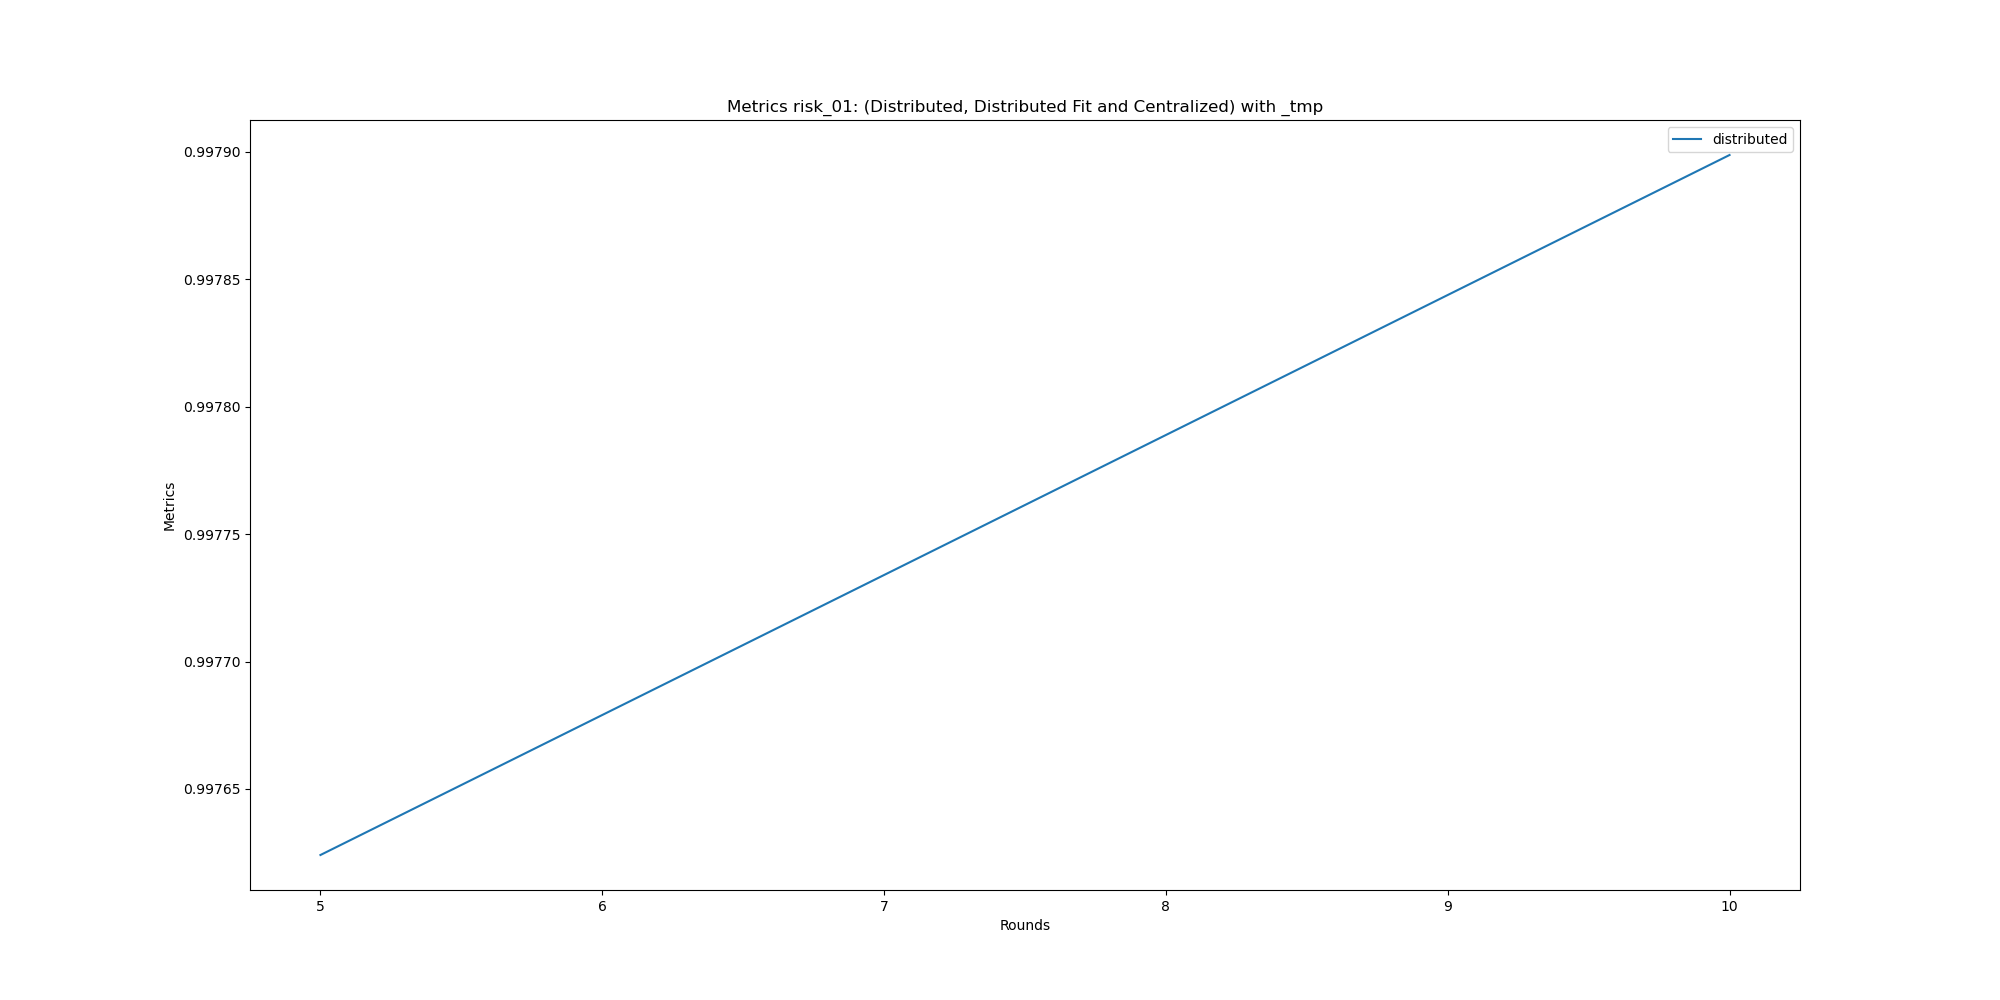

We can see the generalisation bound on the 0-1 loss plot made during the distributed (`aggregated_evaluate` from `./core/strategy.py` method of `GenFLPosterior` class). As we can see the values are vacuous (near 1.), because, for simplicity and fast computation, we made `dryrun=True` and 1 Monte Carlo (MC) Sample (`mc_samples` in the `./conf/scenario/perez_posterior_learnt.yaml`). Making good approximation of the generalisation bound requires at least 10 000 MC Samples (hence several hours, if not days, of computation time)

If you want results from the paper, I advice you to use this configuration:
```yaml
samples_ensemble: 100 # If you want to compare with `Tighter risk certificates for neural networks`, otherwise leave it to 1

pbobj:
    mc_samples: 150_000 # It takes several days, if you want "close" approximation, make it to 10_000 (it takes several hours)
    objective: "fclassic" # choices=["fclassic", "fquad"] these are $f_1$ and $f_2$ in the paper
    kl_penalty: 1. # choices=[1., 0.1] to reproduce the KL Penalty rows in the paper

# Monitoring Params
compute_risk_certificates_every_n_rounds: ${num_rounds} # single evaluation only at the end of the full training routine, this is the moment when the MC Samples are computed
compute_client_risk_certificates_every_n_rounds: ${num_rounds} # single evaluation only at the end of the full training routine, this is the moment when the MC Samples are computed
```

This `${num_rounds}` in the yaml file allow to do interpolation of variable when the file is "resolved". It means that the value of the variable `num_rounds` is replaced at `${num_rounds}`. Some more complex schemes are possible (with custom resolvers). See [variable interpolation](https://omegaconf.readthedocs.io/en/2.3_branch/usage.html#variable-interpolation) in omegaconf docs, a library on which Hydra is built on.

If you want to learn how to make a Posterior from a random Prior (instead of a learnt one), You can check the `Posterior From Random Prior` notebook.

## 2. Dziugaite FL Scenario

We will make mostly like before:  
- run python with YOUR correct `resume_checkpoint_prior`  
- remove `dryrun=True` if you want to run the code entirely  
- the results are not the ones from the paper, for it, you need `pbobj.mc_samples=150000` (and compute the bound certificates only at the very last round, otherwise you will loose a lot of computation time). BE CAREFUL, it takes several hours to days to compute.  

In [ ]:
%%bash

python GenFL_posterior.py \
    +scenario=perez_dziugaite \
    resume_checkpoint_prior='path_to_code/outputs/GenFL_Prior/[Date]/[Time]/+scenario\=perez_dziugaite' \
    dryrun=True \